In [1]:
import pandas as pd
import sklearn
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

Dataframe from MDA_merge_data.ipynb is loaded, datetime column is dropped in order to run model.

In [2]:
df = pd.read_csv("C:\\Users\Arthur\hello\\final_df.csv", delimiter=";")
df['255439'] = df['object_id']==255439
df['255440'] = df['object_id']==255440
df['255441'] = df['object_id']==255441
df['255442'] = df['object_id']==255442
df['255443'] = df['object_id']==255443
df['255444'] = df['object_id']==255444
df['255445'] = df['object_id']==255445
df['280324'] = df['object_id']==280324
df['303910'] = df['object_id']==303910
df = df.sort_values(by=['result_timestamp','object_id'])


In [3]:
df['key'] = df['object_id'].astype('str') + df['result_timestamp']
df['result_timestamp'] = pd.to_datetime(df['result_timestamp'],format='%Y-%m-%d %H:%M:%S')
df_night = df
df_night = df_night.set_index('result_timestamp')
df_night = df_night.between_time('22:00:00','6:00:00', inclusive='left')
df_night = df_night.reset_index()
df_night['hour'] = df_night['hour'].replace(to_replace=22, value=0)
df_night['hour'] = df_night['hour'].replace(to_replace=23, value=1)
df_night['hour'] = df_night['hour'].replace(to_replace=0, value=2)
df_night['hour'] = df_night['hour'].replace(to_replace=1, value=3)
df_night['hour'] = df_night['hour'].replace(to_replace=2, value=4)
df_night['hour'] = df_night['hour'].replace(to_replace=3, value=5)
df_night['hour'] = df_night['hour'].replace(to_replace=4, value=6)
df_night['hour'] = df_night['hour'].replace(to_replace=5, value=7)

In [4]:
df_noisedelay = df_night[['object_id','result_timestamp','laeq']]
df_noisedelay['result_timestamp'] = df_noisedelay['result_timestamp']+pd.DateOffset(days=1)
df_noisedelay['laeq_delayed'] = df_noisedelay['laeq']
df_noisedelay['key'] = df_noisedelay['object_id'].astype('str') + df_noisedelay['result_timestamp'].astype('str')
df_noisedelay = df_noisedelay.drop(['laeq','object_id','result_timestamp'], axis=1)

df_weatherdelay = df_night[['object_id','result_timestamp','LC_HUMIDITY','LC_DWPTEMP','LC_n','LC_RAD','LC_RAININ',
                   'LC_DAILYRAIN','LC_WINDDIR','LC_WINDSPEED','LC_RAD60','LC_TEMP_QCL0']]
df_weatherdelay['result_timestamp'] = df_weatherdelay['result_timestamp']+pd.DateOffset(days=1)
df_weatherdelay['key'] = df_weatherdelay['object_id'].astype('str') + df_weatherdelay['result_timestamp'].astype('str')
df_weatherdelay = df_weatherdelay.drop(['object_id','result_timestamp'], axis=1)
df_night = df_night.drop(['LC_HUMIDITY','LC_DWPTEMP','LC_n','LC_RAD','LC_RAININ',
                'LC_DAILYRAIN','LC_WINDDIR','LC_WINDSPEED','LC_RAD60','LC_TEMP_QCL0'],axis=1)


C:\Users\Arthur\AppData\Local\Temp\ipykernel_14036\2674311159.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noisedelay['result_timestamp'] = df_noisedelay['result_timestamp']+pd.DateOffset(days=1)
C:\Users\Arthur\AppData\Local\Temp\ipykernel_14036\2674311159.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noisedelay['laeq_delayed'] = df_noisedelay['laeq']
C:\Users\Arthur\AppData\Local\Temp\ipykernel_14036\2674311159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [5]:
df_night = pd.merge(df_night,df_noisedelay, on='key',validate='1:1')
df_night = pd.merge(df_night,df_weatherdelay, on='key',validate='1:1')
df_nd = df_night.drop(['key','object_id','result_timestamp','date','time','day_time','day_hour','LC_TEMP_QCL1','LC_TEMP_QCL2','LC_TEMP_QCL3'], axis=1)

In [6]:
df_nd.isna().sum()


laeq             0
hour             0
weekday          0
month            0
weekend          0
holiday          0
exam_period      0
255439           0
255440           0
255441           0
255442           0
255443           0
255444           0
255445           0
280324           0
303910           0
laeq_delayed     0
LC_HUMIDITY     11
LC_DWPTEMP      11
LC_n            11
LC_RAD          11
LC_RAININ       11
LC_DAILYRAIN    11
LC_WINDDIR      11
LC_WINDSPEED    11
LC_RAD60         4
LC_TEMP_QCL0    11
dtype: int64

In [7]:
df_nd = df_nd[df_nd.isna()['LC_HUMIDITY']==False]
df_nd.isna().sum()

laeq            0
hour            0
weekday         0
month           0
weekend         0
holiday         0
exam_period     0
255439          0
255440          0
255441          0
255442          0
255443          0
255444          0
255445          0
280324          0
303910          0
laeq_delayed    0
LC_HUMIDITY     0
LC_DWPTEMP      0
LC_n            0
LC_RAD          0
LC_RAININ       0
LC_DAILYRAIN    0
LC_WINDDIR      0
LC_WINDSPEED    0
LC_RAD60        0
LC_TEMP_QCL0    0
dtype: int64

In [8]:
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Monday', value=0)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Tuesday', value=1)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Wednesday', value=2)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Thursday', value=3)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Friday', value=4)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Saturday', value=5)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Sunday', value=6)

The target dataset (y) and predictor dataset (X) are created. For y, noise is converted to relative noise (proportion of max value)

In [10]:
X

,hour,weekday,month,weekend,holiday,exam_period,255439,255440,255441,255442,...,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0
4,6,6,1,True,True,False,False,False,True,False,...,91.0,11.88,38.0,0.0,0.0,0.0,-48.0,0.04,0.0,13.28
5,6,6,1,True,True,False,False,False,False,True,...,91.0,11.88,38.0,0.0,0.0,0.0,-48.0,0.04,0.0,13.28
6,6,6,1,True,True,False,False,False,False,False,...,91.0,11.88,38.0,0.0,0.0,0.0,-48.0,0.04,0.0,13.28
7,6,6,1,True,True,False,False,False,False,False,...,91.0,11.88,38.0,0.0,0.0,0.0,-48.0,0.04,0.0,13.28
8,6,6,1,True,True,False,False,False,True,False,...,90.0,11.72,37.0,0.0,0.0,0.0,45.0,0.02,0.0,13.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110088,7,5,12,True,True,False,False,False,False,True,...,95.0,12.78,38.0,0.0,0.0,0.0,-167.0,0.02,0.0,13.61
110089,7,5,12,True,True,False,False,False,False,False,...,95.0,12.78,38.0,0.0,0.0,0.0,-167.0,0.02,0.0,13.61
110090,7,5,12,True,True,False,False,False,False,False,...,95.0,12.78,38.0,0.0,0.0,0.0,-167.0,0.02,0.0,13.61
110091,7,5,12,True,True,False,False,False,False,False,...,95.0,12.78,38.0,0.0,0.0,0.0,-167.0,0.02,0.0,13.61


In [9]:
y = df_nd["laeq"]
X = df_nd.drop(["laeq"], axis="columns")

In [36]:
#create time-sensitive split for cross-validation
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=4320,
    max_train_size=22000,
    test_size=16752,
)

In [37]:
#inspect splits
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]
X.iloc[test_0]
X.iloc[train_0]

,hour,weekday,month,weekend,holiday,exam_period,255439,255440,255441,255442,...,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0
6,6,6,1,True,True,False,False,False,False,False,...,91.0,11.88,38.0,0.0,0.0,0.0,-48.0,0.04,0.0,13.28
7,6,6,1,True,True,False,False,False,False,False,...,91.0,11.88,38.0,0.0,0.0,0.0,-48.0,0.04,0.0,13.28
8,6,6,1,True,True,False,False,False,True,False,...,90.0,11.72,37.0,0.0,0.0,0.0,45.0,0.02,0.0,13.28
9,6,6,1,True,True,False,False,False,False,True,...,90.0,11.72,37.0,0.0,0.0,0.0,45.0,0.02,0.0,13.28
10,6,6,1,True,True,False,False,False,False,False,...,90.0,11.72,37.0,0.0,0.0,0.0,45.0,0.02,0.0,13.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22001,6,3,4,False,True,False,False,False,False,False,...,80.0,6.61,35.0,0.0,0.0,0.0,-39.0,0.25,0.0,9.97
22002,6,3,4,False,True,False,False,False,False,False,...,80.0,6.61,35.0,0.0,0.0,0.0,-39.0,0.25,0.0,9.97
22003,7,3,4,False,True,False,True,False,False,False,...,80.0,6.61,36.0,0.0,0.0,0.0,-67.0,0.14,0.0,9.89
22004,7,3,4,False,True,False,False,True,False,False,...,80.0,6.61,36.0,0.0,0.0,0.0,-67.0,0.14,0.0,9.89


In [38]:
train_4, test_4 = all_splits[4]
X.iloc[test_4]
X.iloc[train_4]

,hour,weekday,month,weekend,holiday,exam_period,255439,255440,255441,255442,...,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0
67021,7,4,8,False,True,False,False,False,True,False,...,89.0,17.02,32.0,7.0,0.0,0.0,-37.0,0.0,0.0,18.78
67022,7,4,8,False,True,False,False,False,False,True,...,89.0,17.02,32.0,7.0,0.0,0.0,-37.0,0.0,0.0,18.78
67023,7,4,8,False,True,False,False,False,False,False,...,89.0,17.02,32.0,7.0,0.0,0.0,-37.0,0.0,0.0,18.78
67024,7,4,8,False,True,False,False,False,False,False,...,89.0,17.02,32.0,7.0,0.0,0.0,-37.0,0.0,0.0,18.78
67025,7,4,8,False,True,False,False,False,False,False,...,89.0,17.02,32.0,7.0,0.0,0.0,-37.0,0.0,0.0,18.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89016,7,0,10,False,False,False,False,False,False,False,...,87.0,12.46,37.0,0.0,0.0,0.0,0.0,0.0,0.0,14.58
89017,7,0,10,False,False,False,False,False,True,False,...,87.0,12.39,38.0,0.0,0.0,0.0,0.0,0.0,0.0,14.50
89018,7,0,10,False,False,False,False,False,False,True,...,87.0,12.39,38.0,0.0,0.0,0.0,0.0,0.0,0.0,14.50
89019,7,0,10,False,False,False,False,False,False,False,...,87.0,12.39,38.0,0.0,0.0,0.0,0.0,0.0,0.0,14.50


In [48]:
# grid search for hyperparameter tuning

param_grid = {
    'learning_rate': (0.04,0.06),
    'n_estimators': (100,130,150),
    'max_depth' : (3,4,5)}
model = xgb.XGBRegressor()
model_grid_search = GridSearchCV(model, param_grid=param_grid,
                                 n_jobs=2, cv=ts_cv)
model_grid_search.fit(X, y)


GridSearchCV(cv=TimeSeriesSplit(gap=4320, max_train_size=22000, n_splits=5, test_size=16752),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=Non...
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=2,
             param_grid={'learning_rate': (0.04, 0.06), 'max_depth': (3, 4, 5),
                         'n_estimators': (100, 130, 150)})

In [49]:
accuracy = model_grid_search.score(X, y)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)

The test accuracy score of the grid-searched pipeline is: 0.68


In [50]:
model_grid_search.predict(X.iloc[0:5])

array([51.750973, 46.843548, 46.41891 , 44.694992, 50.23419 ],
      dtype=float32)

In [51]:
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")

The best set of parameters is: {'learning_rate': 0.06, 'max_depth': 3, 'n_estimators': 100}


In [43]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.714111,0.329553,0.085988,0.010654,0.06,4,150,"{'learning_rate': 0.06, 'max_depth': 4, 'n_est...",0.547825,0.502100,0.640029,0.051720,0.524738,0.453282,0.206181,1
2,3.171666,0.089206,0.092005,0.005175,0.06,4,170,"{'learning_rate': 0.06, 'max_depth': 4, 'n_est...",0.540424,0.500075,0.636652,0.056618,0.524361,0.451626,0.202874,2
1,2.281322,0.114133,0.079994,0.009892,0.06,4,160,"{'learning_rate': 0.06, 'max_depth': 4, 'n_est...",0.545225,0.502410,0.637605,0.043145,0.524585,0.450594,0.208855,3
9,2.722291,0.016670,0.087977,0.001983,0.07,4,150,"{'learning_rate': 0.07, 'max_depth': 4, 'n_est...",0.550884,0.501398,0.630563,0.014928,0.520624,0.443679,0.218860,4
18,2.727595,0.029792,0.089278,0.001889,0.08,4,150,"{'learning_rate': 0.08, 'max_depth': 4, 'n_est...",0.546568,0.490901,0.631194,0.030898,0.515609,0.443034,0.211442,5


In [44]:
# get the parameter names
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

In [45]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,param_learning_rate,param_n_estimators,param_max_depth,mean_test_score,std_test_score,rank_test_score
0,0.06,150,4,0.453282,0.206181,1
2,0.06,170,4,0.451626,0.202874,2
1,0.06,160,4,0.450594,0.208855,3
9,0.07,150,4,0.443679,0.218860,4
18,0.08,150,4,0.443034,0.211442,5
10,0.07,160,4,0.441161,0.218873,6
11,0.07,170,4,0.439022,0.216296,7
3,0.06,150,5,0.424350,0.216662,8
19,0.08,160,4,0.422064,0.248081,9
4,0.06,160,5,0.415159,0.227390,10


In [46]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["param_max_depth"],
    columns=["param_n_estimators"])

pivoted_cv_results

param_n_estimators,150,160,170
param_max_depth,,,
4,0.446665,0.437940,0.432023
5,0.401776,0.394902,0.387420
6,0.362320,0.353954,0.344688


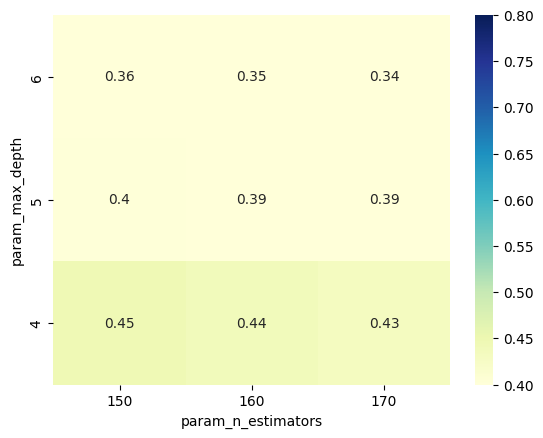

In [47]:
import seaborn as sns

ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.4,
                 vmax=0.8)
ax.invert_yaxis()

In [52]:
#run XGBoost model
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

gbrt_pipeline = xgb.XGBRegressor(learning_rate=0.07,n_estimators=160,max_depth=5)

evaluate(gbrt_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     3.766 +/- 0.979
Root Mean Squared Error: 5.025 +/- 1.245


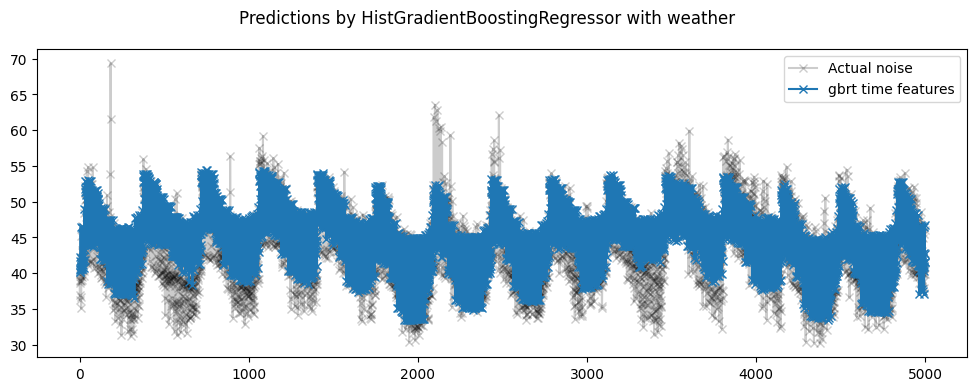

In [53]:
#Qualitative analysis of the impact of features on linear model predictions
gbrt_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
gbrt_predictions = gbrt_pipeline.predict(X.iloc[test_0])

last_hours = slice(-5000, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by HistGradientBoostingRegressor with weather")
ax.plot(
    y.iloc[test_0].values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual noise",
    color="black",
)
ax.plot(gbrt_predictions[last_hours], "x-", label="gbrt time features")
_ = ax.legend()


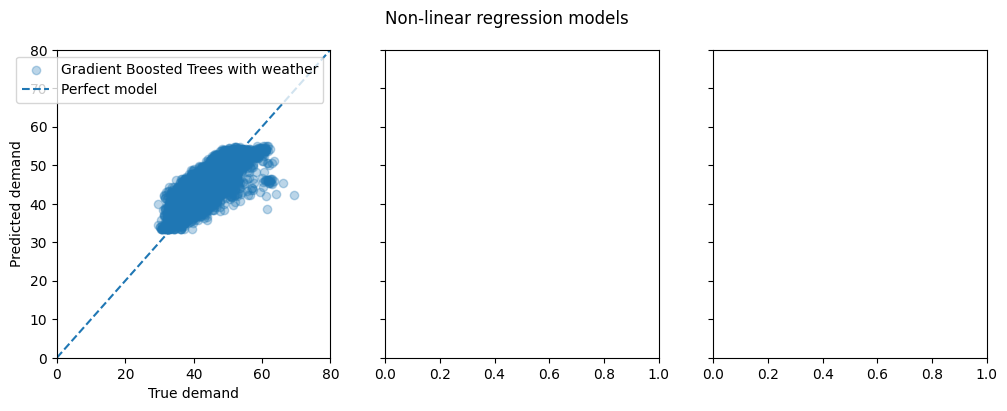

In [54]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
fig.suptitle("Non-linear regression models")
predictions = [
    gbrt_predictions,
]
labels = [
    "Gradient Boosted Trees with weather",
]
for ax, pred, label in zip(axes, predictions, labels):
    ax.scatter(y.iloc[test_0].values, pred, alpha=0.3, label=label)
    ax.plot([0, 80], [0, 80], "--", label="Perfect model")
    ax.set(
        xlim=(0, 80),
        ylim=(0, 80),
        xlabel="True demand",
        ylabel="Predicted demand",
    )
    ax.legend()

plt.show()

In [ ]:
#now do the same but look at variables separately: 
# the feature importance should be lower, because dropping a variable form the model 
# will not result in a large decrease of information gain, etc if the other correlated variables take over the task of explaining the model 
#example: you can see that weekend is not as important anymore, because day takes over if weekend is in the model
features=['hour','weekday','month','weekend','holiday','exam_period','LC_HUMIDITY','LC_DWPTEMP','LC_n',
          'LC_RAD','LC_RAININ','LC_DAILYRAIN','LC_WINDDIR','LC_WINDSPEED','LC_RAD60','LC_TEMP_QCL0']
imp = importances(gbrt_pipeline, X, y, features=features) # permutation
#should be on fitted model. I used the X and y but usualy you would need to use the validation set
viz = plot_importances(imp)
viz.view()

NameError: name 'importances' is not defined